In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd

In [9]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [17]:
# Trip Start and End Date
trip_start_date = '2017-01-15'
trip_end_date = '2017-01-18'

In [18]:
# Find the last date point in the datebase
last_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date_obj = dt.datetime.strptime(last_date_str, '%Y-%m-%d')
last_date_obj

datetime.datetime(2017, 8, 23, 0, 0)

In [19]:
# Calculate the date 1 year ago from the last data point in the database
last_one_year_date_obj = last_date_obj - dt.timedelta(days=365)
last_one_year_date_str = last_one_year_date_obj.strftime('%Y-%m-%d')
last_one_year_date_str

'2016-08-23'

In [20]:
# Perform a query to retrieve the data and precipitation scores
orm_query_data = session.query(Measurement.date, Measurement.prcp) \
                        .filter(Measurement.date >= last_one_year_date_str, Measurement.date <= last_date_str) \
                        .order_by(Measurement.date).all()
orm_query_data

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [21]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(orm_query_data)
df = df.set_index('date')
df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [22]:
# Sort the dataframe by date
df= df.sort_index(ascending=True)
df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


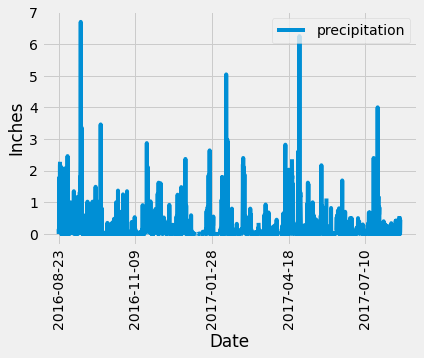

In [23]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.legend(['precipitation'], loc='upper right')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.rename(columns = {'prcp':'precipitation'}, inplace = True) 
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).distinct().count()
stations

9

In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_counts = session.query(Measurement.station, func.count(Measurement.station)) \
                        .group_by(Measurement.station) \
                        .order_by(func.count(Measurement.station).desc()) \
                        .first()
active_station = stations_counts[0]
active_station

'USC00519281'

In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
recorded_temperature = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
                                .filter(Measurement.station == active_station) \
                                .all()
recorded_temperature 

[(54.0, 85.0, 71.66378066378067)]

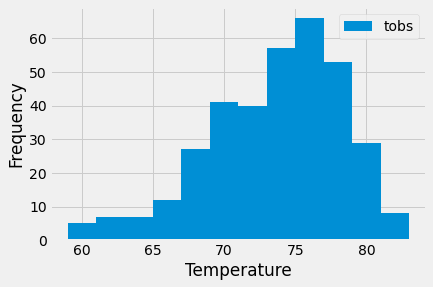

In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = session.query(Measurement.tobs) \
                .filter(Measurement.station == active_station) \
                .filter(Measurement.date >= last_one_year_date_str, Measurement.date <= last_date_str) \
                .order_by(Measurement.date).all()

df_histogram = pd.DataFrame(data, columns=['tobs'])

df_histogram.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temperatures = calc_temps(trip_start_date, trip_end_date)
trip_temperatures = trip_temperatures[0]
trip_temperatures

(66.0, 71.625, 80.0)

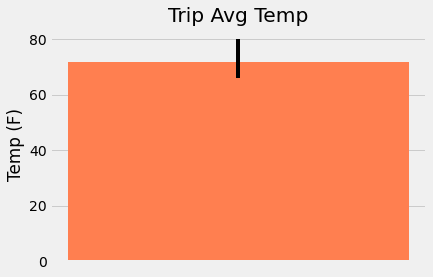

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp = trip_temperatures[0]
avg_temp = trip_temperatures[1]
max_trip = trip_temperatures[2]

min_error = avg_temp - min_temp
max_error = max_trip - avg_temp 

error_bars = np.array([[min_error], [max_error]])

plt.bar(0, avg_temp, yerr=error_bars, color='coral')
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xticks([])
plt.show()

In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_start_date_obj = dt.datetime.strptime(trip_start_date, '%Y-%m-%d')
previous_year_trip_start_date_obj = trip_start_date_obj - dt.timedelta(days=365)
previous_year_trip_start_date_str = previous_year_trip_start_date_obj.strftime('%Y-%m-%d')

trip_end_date_obj = dt.datetime.strptime(trip_end_date, '%Y-%m-%d')
previous_year_trip_end_date_obj = trip_end_date_obj - dt.timedelta(days=365)
previous_year_trip_end_date_str = previous_year_trip_end_date_obj.strftime('%Y-%m-%d')


rainfall_data = session.query(Measurement.station,Station.name, Station.latitude, Station.longitude, Station.elevation) \
                            .group_by(Measurement.station) \
                            .join(Station, Measurement.station == Station.station) \
                            .filter(Measurement.date >= previous_year_trip_start_date_str, Measurement.date <= previous_year_trip_end_date_str) \
                            .order_by(Measurement.prcp.desc()) \
                            .all()
df_rainfall = pd.DataFrame(rainfall_data)
df_rainfall.head()

,station,name,latitude,longitude,elevation
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

In [35]:
# Set the start and end date of the trip
trip_start_date = '2018-01-01'
trip_end_date = '2018-01-07'

In [36]:
# Use the start and end date to create a range of dates
trip_dates_obj_list = pd.date_range(start=trip_start_date, end=trip_end_date).to_pydatetime().tolist()
trip_dates_obj_list

[datetime.datetime(2018, 1, 1, 0, 0),
 datetime.datetime(2018, 1, 2, 0, 0),
 datetime.datetime(2018, 1, 3, 0, 0),
 datetime.datetime(2018, 1, 4, 0, 0),
 datetime.datetime(2018, 1, 5, 0, 0),
 datetime.datetime(2018, 1, 6, 0, 0),
 datetime.datetime(2018, 1, 7, 0, 0)]

In [37]:
# Stip off the year and save a list of %m-%d strings
trip_dates = []
for date_obj in trip_dates_obj_list:
    trip_dates.append(date_obj.strftime('%m-%d'))
trip_dates

['01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07']

In [38]:
# Loop through the list of %m-%d strings and calculate the normals for each date
for i in trip_dates:
    normals.append(daily_normals(i)[0])

normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals,index=trip_dates, columns=['Minimum Temperature','Average Temperature','Maximum Temperature']) 
normals_df.index.name = 'date'
normals_df

,Minimum Temperature,Average Temperature,Maximum Temperature
date,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0


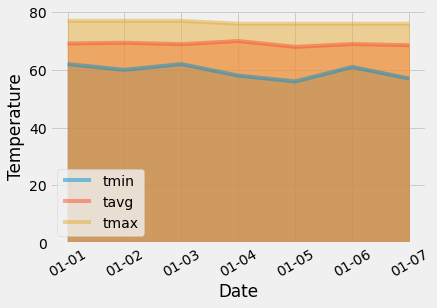

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)
plt.legend(['tmin', 'tavg', 'tmax'], loc='lower left')
plt.xticks(rotation=30)
plt.xlabel('Date',)
plt.ylabel('Temperature')
plt.show()

In [51]:
# Temperature Analysis I

In [61]:
from scipy import stats

In [62]:
hw_df = pd.read_csv('Resources/hawaii_measurements.csv')
hw_df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [63]:
hw_df['date'] =  pd.to_datetime(hw_df['date'], format='%Y-%m-%d')
hw_df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [64]:
june_df = hw_df[hw_df['date'].dt.month == 6]
june_df = june_df.dropna()
june_df = june_df.reset_index()
june_df = june_df[['date', 'tobs']]
june_df.head()

,date,tobs
0,2010-06-01,78
1,2010-06-02,76
2,2010-06-03,78
3,2010-06-04,76
4,2010-06-05,77


In [65]:
december_df = hw_df[hw_df['date'].dt.month == 12]
december_df = december_df.dropna()
december_df = december_df.reset_index()
december_df = december_df[['date', 'tobs']]
december_df.head()

,date,tobs
0,2010-12-01,76
1,2010-12-03,74
2,2010-12-04,74
3,2010-12-06,64
4,2010-12-07,64


In [66]:
avg_temp_june = june_df['tobs'].mean()
avg_temp_june

74.88754764930114

In [67]:
avg_temp_december = december_df['tobs'].mean()
avg_temp_december

70.93024911032029

In [68]:
result = stats.ttest_rel(june_df[['tobs']].head(),december_df[['tobs']].head())
result

Ttest_relResult(statistic=array([2.70346534]), pvalue=array([0.05390054]))

In [69]:
# Paired T Test is used for the above observation
# It is used because Paired T Test are used when two related samples have identical average.
# In the above case, the average temperatures for june and december are almost identical